In [39]:
import pandas as pd
import numpy as np

# load a csv table
led = pd.read_csv('/media/mpicek/T7/martin/data/log_sync_led.csv')
acc = pd.read_csv('/media/mpicek/T7/martin/data/log_sync_acc.csv')
acc = acc.drop_duplicates()
led = led.drop_duplicates()

# join the table based on mp4_name
df = pd.merge(led, acc, on='mp4_name', how='inner', suffixes=('_led', '_acc'))
total = df.shape[0]

df = df.query('passed_quality_test == True')
led_properly = df.shape[0]
print('Total:', total)
print('Properly synchronized by LED:', led_properly)
print("LED succes = ", round(100*led_properly/total, 2), "%")
print(f"Overall we have approx", int(np.sum(df["mp4_length_acc"]) / 3600), "hours of video")

Total: 529
Properly synchronized by LED: 268
LED succes =  50.66 %
Overall we have approx 46 hours of video


In [40]:
# compute the lag difference and sort by it (absolute value)
df['lag_diff'] = df['lag_led'] - df['lag_acc']
df['lag_diff_time_ms'] = (1000/585) *(df['lag_led'] - df['lag_acc'])
df['abs_lag_diff'] = np.abs(df['lag_diff'])
df = df.sort_values('abs_lag_diff')

In [41]:
# get only those that were possible to compare
df = df[df['sync_failed_led'] == 0]
df = df[df['sync_failed_acc'] == 0]

comparable = df.shape[0]
print('Comparable:', comparable)
print(f"Overall comparable:", int(np.sum(df["mp4_length_acc"]) / 3600), "hours of video")

(253, 26)
(253, 26)
Comparable: 253
Overall comparable: 46 hours of video


In [4]:
max_difference_ms = 150
acc_properly_df = df.query(f'abs_lag_diff < {max_difference_ms}')
acc_properly = acc_properly_df.shape[0]
print('Properly synchronized by the accelerometer:', acc_properly)
# print acc_succes with only two numbers behind the dot
print("Acc succes = ", round(100*acc_properly/comparable, 2), "%")


Properly synchronized by the accelerometer: 221
Acc succes =  87.35 %


In [5]:
metric_threshold = 5
marked_as_successful = df.query(f'additional_peaks_per_million_acc < {metric_threshold}')
num_of_marked_as_successful = marked_as_successful.shape[0]
print('Marked as successful by the accelerometer:', num_of_marked_as_successful)

Marked as successful by the accelerometer: 208


In [6]:
TP = df.query(f'additional_peaks_per_million_acc < {metric_threshold} and abs_lag_diff < {max_difference_ms}').shape[0]
FP = num_of_marked_as_successful - TP   # df.query(f'additional_peaks_per_million_acc < {metric_threshold} and abs_lag_diff >= {max_difference_ms}')
FN = acc_properly - TP                  # df.query(f'additional_peaks_per_million_acc >= {metric_threshold} and abs_lag_diff < {max_difference_ms}')
TN = comparable - TP - FP - FN
print('TP:', TP, " ... so we include in our dataset ", round(100*TP/acc_properly, 2), "% of properly synchronized data")
print('FP:', FP, " ... so our dataset will consist of ", round(100*FP/(TP + FP), 2), "% of incorrectly synchronized data (we want to minimize this)")
print('FN:', FN, " ... so we lost ", round(100*FN/acc_properly, 2), "% of properly synchronized (=good) data")
print('TN:', TN, " ... so we properly discarded ", round(100*TN/(TN + FP), 2), "% of incorrectly synchronized data")

print("Overall, we use ", round(100*(TP + FP)/comparable, 2), "% of all the (comparable) data.")
# make a table from the TP, FP, FN, TN
confusion_matrix = pd.DataFrame([[TP, FP], [FN, TN]], index=['Metric said "correct sync"', 'Matric said "incorrect sync"'], columns=['Actually proper sync', 'Actually incorrect sync'])
print(confusion_matrix)

TP: 205  ... so we include in our dataset  92.76 % of properly synchronized data
FP: 3  ... so our dataset will consist of  1.44 % of incorrectly synchronized data (we want to minimize this)
FN: 16  ... so we lost  7.24 % of properly synchronized (=good) data
TN: 29  ... so we properly discarded  90.62 % of incorrectly synchronized data
Overall, we use  82.21 % of all the (comparable) data.
                              Actually proper sync  Actually incorrect sync
Metric said "correct sync"                     205                        3
Matric said "incorrect sync"                    16                       29


## How bad are the False Positives?
#### Will they destry our dataset a lot?

In [7]:
df.query(f'additional_peaks_per_million_acc < {metric_threshold} and abs_lag_diff >= {max_difference_ms}')[['abs_lag_diff']]

,abs_lag_diff
220,152.0
422,158.0
203,159.0


## Why are some videos hard to sync with the accelerometer?

Average length of incorrectly synchronized videos: 4.48 minutes
Average length of correctly synchronized videos: 11.98 minutes
Variance of length of incorrectly synchronized videos: 12.93 minutes
Variance of length of correctly synchronized videos: 93.96 minutes


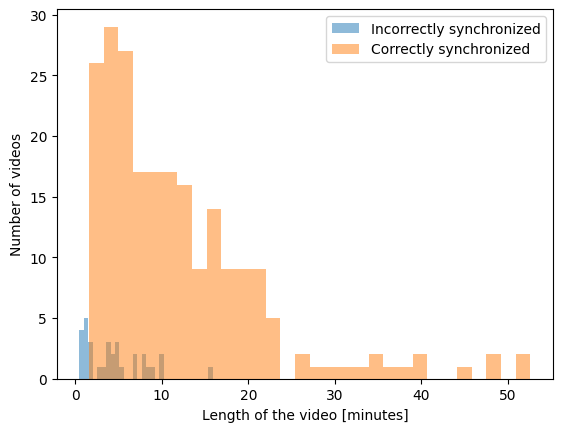

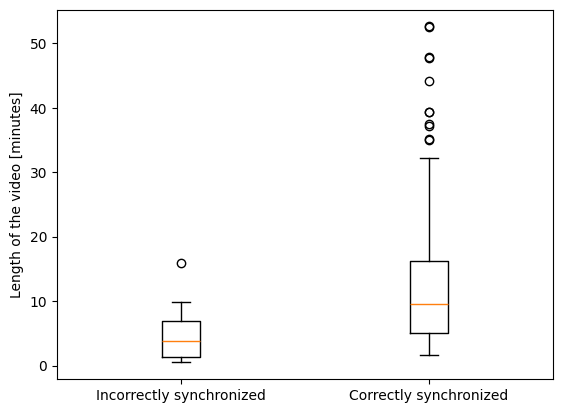

In [8]:
incorrect = df.query(f'abs_lag_diff >= {max_difference_ms}')
incorrect_length = incorrect['mp4_length_acc'].mean() / 60
correct_length = acc_properly_df['mp4_length_acc'].mean() / 60
print('Average length of incorrectly synchronized videos:', round(incorrect_length, 2), 'minutes')
print('Average length of correctly synchronized videos:', round(correct_length, 2), 'minutes')
incorrect_var = (incorrect['mp4_length_acc'] / 60).var()
correct_var = (acc_properly_df['mp4_length_acc'] / 60).var()
print('Variance of length of incorrectly synchronized videos:', round(incorrect_var, 2), 'minutes')
print('Variance of length of correctly synchronized videos:', round(correct_var, 2), 'minutes')
# plot that on graph
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(incorrect['mp4_length_acc']/60, bins=30, alpha=0.5, label='Incorrectly synchronized')
ax.hist(acc_properly_df['mp4_length_acc']/60, bins=30, alpha=0.5, label='Correctly synchronized')
ax.set_xlabel('Length of the video [minutes]')
ax.set_ylabel('Number of videos')
ax.legend()
plt.show()

# plot that with boxplot
fig, ax = plt.subplots()
ax.boxplot([incorrect['mp4_length_acc']/60, acc_properly_df['mp4_length_acc']/60], labels=['Incorrectly synchronized', 'Correctly synchronized'])
ax.set_ylabel('Length of the video [minutes]')
plt.show()

